# Tutorial: Community causal graph reconstruction

The algorithm implemented in the 'CausalGraph' class employes the Differentiable Information Imbalance (DII) to construct a "community causal graph" from time series data. 

This notebook shows a tutorial of the methods implemented in this class. For more information, please refer to the causal_graph module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [1]:
import numpy as np
import networkx as nx
from dadapy import CausalGraph
import matplotlib.pyplot as plt
import jax
import os
import time

jax.config.update('jax_platform_name', 'cpu') # can run on 'cpu' or 'gpu'; restart the
                                              # notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false' # avoid jax memory preallocation

In [2]:
%load_ext autoreload
%autoreload 2

Given a set of $D$ dynamical variables $\{ x^\alpha(t)\}_{\alpha = 1}^D$, the algorithm aims at splitting the dynamical variables in groups with different levels of autonomy. We call $\mathcal{S}^\beta = \{x^\beta\}$ an autonomous subset if each (direct or indirect) cause of any variable $x^\beta \in \mathcal{S}^\beta$ also belongs to $\mathcal{S}^\beta$.

In the first step of the algorithm, $\forall \alpha=1,...,D$ we minimize

$$
    DII(\boldsymbol{w}\odot \boldsymbol{x}(t=0) \rightarrow x^\alpha(t=\tau))\,.
$$
Here, $\boldsymbol{w}$ is a vector of $D$ parameters weighting each dynamical variable, and $\odot$ denotes the element-wise product. The test is repeated by scanning several values of $\tau$, choosing $\tau$ in a range where $x^\alpha(t=\tau)$ has not significantly decorrelated from $x^\alpha(t=0)$.

This first part of the algorithm is carried out by the method 'optimize_present_to_future', which returns the final weights for each optimization and the corresponding DII over all the training epochs.
In this tutorial, the input file contains a 9-dimensional trajectory of three Rossler systems $X$, $Y$ and $Z$ (columns 0:3, 3:6, 6:9), such that $X$ causes $Z$ and $Y$ causes $Z$ ($X$ and $Y$ are autonomous). Therefore, the ground-truth community graph that we aim to retrieve is $[0,1,2]\rightarrow [6,7,8] \leftarrow [3,4,5]$.

In [3]:
traj = np.load('./datasets/three_rossler_systems.npy')
print(traj.shape)

nvars = traj.shape[1]

(205001, 9)


Then, we run the optimization of the DII over all target variables. The choice of the appropriate time lags requires computing the autocorrelation functions of the variables, which is for simplicity omitted in this tutorial.

In [4]:
num_samples = 2000
num_epochs = 300
batches_per_epoch = 20
k = 5
time_lags = [10,30] # time lags tested

g = CausalGraph(time_series=traj, seed=0) # object of the class CausalGraph

weights_final, imbs_training, _, _ = (
    g.optimize_present_to_future(
        num_samples=num_samples,
        time_lags=time_lags,
        target_variables="all",
        save_weights=False,
        embedding_dim_present=1,
        embedding_dim_future=1,
        embedding_time=1,
        num_epochs=num_epochs,
        batches_per_epoch=batches_per_epoch,
        l1_strength=0.,
        point_adapt_lambda=True,
        k_init=k,
        k_final=k,
        lambda_factor=0.1,
        params_init=None,
        optimizer_name="adam",
        learning_rate=1e-2,
        learning_rate_decay="cos",
        num_points_rows=None,
        compute_imb_final=False,
        compute_error=False,
        ratio_rows_columns=None,
        discard_close_ind=None
    )
)

2025-02-05 00:54:17.888986: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Training (target_var=0, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=0, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=1, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=1, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=2, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=2, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=3, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=3, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=4, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=4, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=5, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=5, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=6, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=6, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=7, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=7, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=8, tau=10):   0%|          | 0/300 [00:00<?, ?it/s]

Training (target_var=8, tau=30):   0%|          | 0/300 [00:00<?, ?it/s]

Plot the DII during the training for all target variables and all tested time lags, together with the optimized final weights

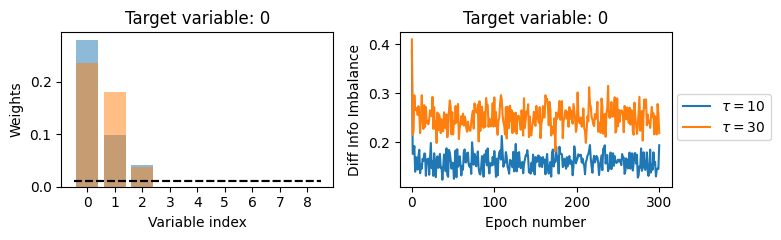

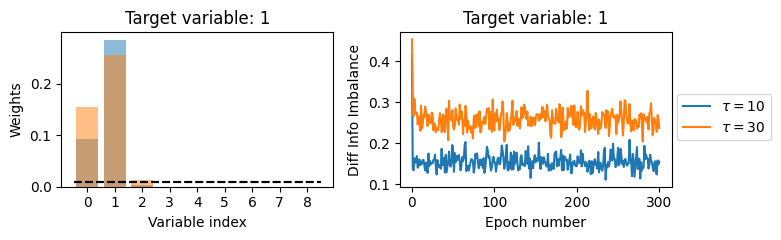

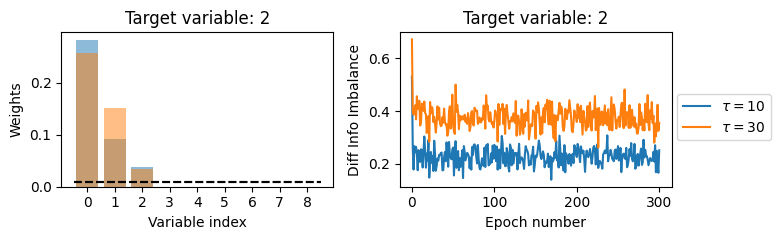

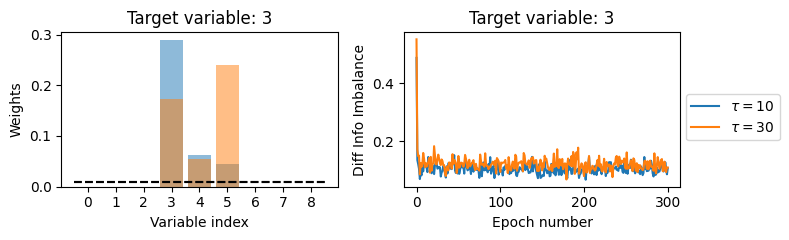

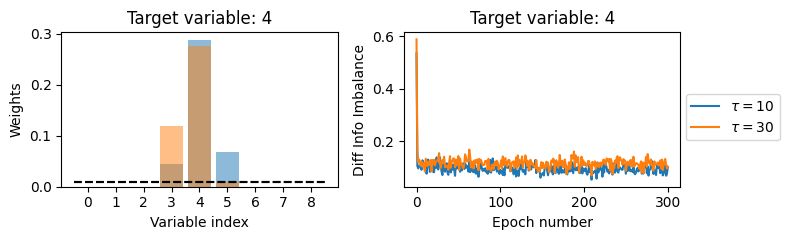

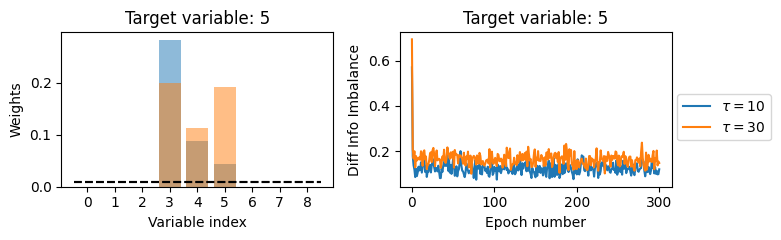

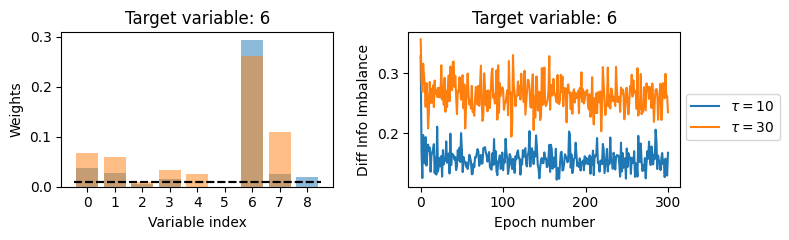

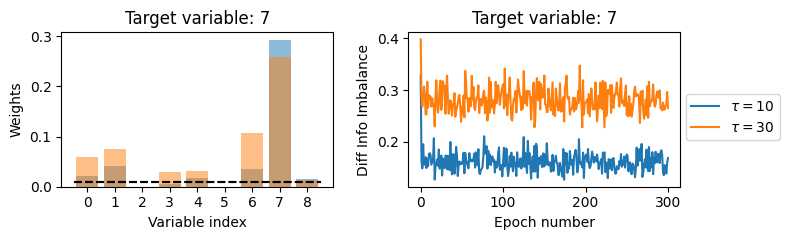

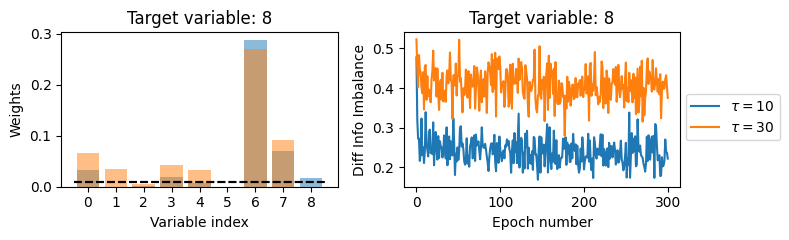

In [13]:
threshold = 0.01 # visualize threshold used in the next step of the algorithm

for ivar in range(nvars):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,2.5))
    for jtau, tau in enumerate(time_lags):
        ax1.bar(np.arange(nvars), weights_final[ivar,jtau], label=f"$\\tau = {tau}$", alpha=0.5)
        ax1.hlines(threshold, -0.5, nvars-1+0.5, linestyle="--", color="black")
        ax1.set(xlabel="Variable index", ylabel="Weights", title=f"Target variable: {ivar}")

        ax2.plot(imbs_training[ivar, jtau], label=f"$\\tau = {tau}$")
        ax2.set(xlabel="Epoch number", ylabel="Diff Info Imbalance", title=f"Target variable: {ivar}")

    ax2.legend(loc=(1.02,0.3))
    ax1.set_xticks(np.arange(nvars))
    fig.tight_layout()
    fig.show()

In the next step of the pipeline, an adjacency matrix defining a directed graph is constructed. Each node represents a dynamical variable and a link $x^\alpha \rightarrow x^\beta$ is interpreted as the presence of a direct link or indirect link (i.e. mediated by other variables) between $x^\alpha$ and $x^\beta$, at some unspecified time lag. Importantly, not all the indirect links are explicitely represented in this graph, as $x^\alpha$ and $x^\beta$ could be linked either if a link $x^\alpha\rightarrow x^\beta$ is present or if the two variables are linked by an oriented path $x^\alpha\rightarrow...\rightarrow x^\beta$.

To construct the adjacency matrix, for each pair $x^\alpha \rightarrow x^\beta$ only the maximum weight found over all tested time lags is retained. If such a weight is larger than the chosen threshold, the corresponding entry of the adjacency is set to 1, otherwise it is set to 0.

In [18]:
threshold = 0.01
adj_matrix = g.compute_adj_matrix(weights=weights_final, threshold=threshold)
print(adj_matrix)

[[1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]]


Finally, the above adjacency matrix is employed to identify the "dynamical communities" and their "level of autonomy".

The scheme of the algorithm is the following:

    1. for each node (dynamical variable), all the ancestors are identified by following backward the arrows of the graph. By definition, the ancestors of a variable compose the autonomous subset to which the variable belongs.

    2. the following steps are iterated over an integer variable 'level', which defines the step of the algorithm at which a community becomes autonomous, namely its 'level of autonomy'. The steps are repeated until all the variables have been assigned to a group.

        2.1. Take the smallest set among the autonomous sets available at the current step. This set is necessairly a dynamical community.

        2.2. Find all the autonomous sets which have empty intersection with the dynamical community identified at step 2.1. All these sets define other communities with the same level of autonomy.

        2.3 Delete from the remaining autonomous sets all the variables that have been assigned to a community, and iterate.

The output of the algorithm, implemented in the method 'find_communities', is a dictionary with pairs (comm_id, level) as keys and lists containing the indices of the variables in each community as values. 'comm_id' is an integer number identifying the group, while 'level' is an integer identifying the step of the algorithm at which the group is identified, namely its level of autonomy. Both 'comm_id' and 'level' start from 0.

In [19]:
community_dictionary = g.find_communities(adj_matrix=adj_matrix)
print(community_dictionary)

{(0, 0): [0, 1, 2], (1, 0): [3, 4, 5], (2, 1): [6, 7, 8]}


Finally, the communities identified at the previous step can be represented as single nodes in a causal graph, where a link is drawn only between communities $G^\alpha$ and $G^\beta$ if at least a variable in $G^\alpha$ is linked to a variable in $G^\beta$ in the original all-variable graph. Directed arrows between communities linked by indirect paths ($G^\alpha\rightarrow ... \rightarrow G^\beta$) are omitted. The following method draws the community causal graph and returns an object of the networkx.DiGraph class.

Community A (3 variables, level 0): (0, 1, 2)
Community B (3 variables, level 0): (3, 4, 5)
Community C (3 variables, level 1): (6, 7, 8)


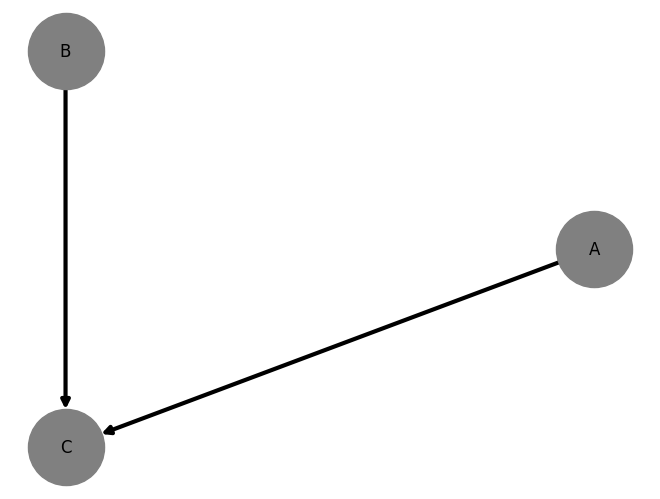

In [20]:
G = g.community_graph_visualization(community_dictionary=community_dictionary,
                                    adj_matrix=adj_matrix,
                                    type="community",
                                    savefig_name=None)

The same method also supports an "all-variable" representation, where variables in the same community are identified by different colors:

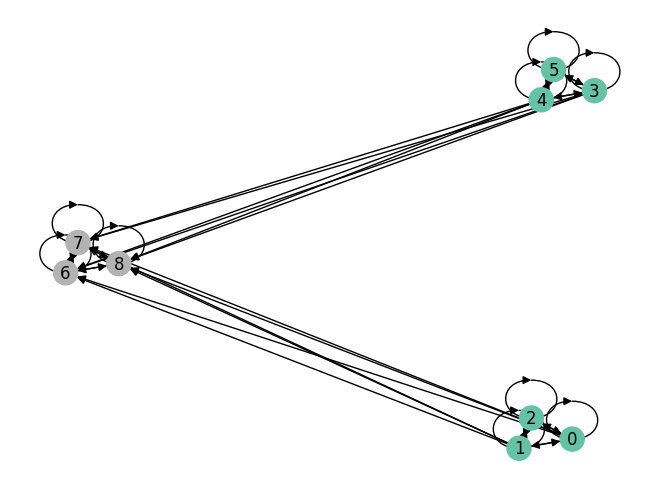

In [21]:
G = g.community_graph_visualization(community_dictionary=community_dictionary,
                                    adj_matrix=adj_matrix,
                                    type="all-variable",
                                    savefig_name=None,
                                    cmap='Set2')